<a href="https://colab.research.google.com/github/VirajMadushan/student-score-prediction/blob/main/CIS6005_Predicting_Student_Test_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Student Test Scores
### Kaggle Playground Series – S6E1

**Name:** W.G.Viraj Madushan Jayaweera  
**Student ID:** KD/BSCSD/20/02  
**Module:** CIS6005 – Deep Learning  
**Tool:** Google Colab + Kaggle


## 1. Setup


In [1]:
# Install required libraries
!pip -q install kaggle
!pip -q install pandas numpy matplotlib seaborn
!pip -q install scikit-learn
!pip -q install tensorflow


In [2]:
# Import libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge


In [3]:
# Configure Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions list | head


ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd       1202           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           200,000 Usd        568           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd        125           False  
https://www.kaggle.com/competitions/csiro-biomass                                   2026-01-28 23:59:00  Research            75,000 Usd       3070           False  
https://ww

## 2. Load Data


In [5]:
# Download Kaggle competition data
!kaggle competitions download -c playground-series-s6e1


  0% 0.00/13.8M [00:00<?, ?B/s]
100% 13.8M/13.8M [00:00<00:00, 1.41GB/s]


In [6]:
# Unzip the downloaded dataset
!unzip -o playground-series-s6e1.zip


Archive:  playground-series-s6e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [7]:
# Load datasets
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")

# Basic checks
train_df.head(), train_df.shape


(   id  age  gender   course  study_hours  class_attendance internet_access  \
 0   0   21  female     b.sc         7.91              98.8              no   
 1   1   18   other  diploma         4.95              94.8             yes   
 2   2   20  female     b.sc         4.68              92.6             yes   
 3   3   19    male     b.sc         2.00              49.5             yes   
 4   4   23    male      bca         7.65              86.9             yes   
 
    sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
 0          4.9       average  online videos             low            easy   
 1          4.7          poor     self-study          medium        moderate   
 2          5.8          poor       coaching            high        moderate   
 3          8.3       average    group study            high        moderate   
 4          9.6          good     self-study            high            easy   
 
    exam_score  
 0        78.3  
 1      

In [8]:
# Identify target column
target_col = list(set(train_df.columns) - set(test_df.columns))
target_col


['exam_score']

## 3. Exploratory Data Analysis (EDA)


In [9]:
# Dataset overview
print("Train shape:", train_df.shape)
print("\nColumn names:")
train_df.columns


Train shape: (630000, 13)

Column names:


Index(['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [10]:
# Data types
train_df.dtypes


,0
id,int64
age,int64
gender,object
course,object
study_hours,float64
class_attendance,float64
internet_access,object
sleep_hours,float64
sleep_quality,object
study_method,object


“The dataset consists of 630,000 student records with a mix of numerical and categorical attributes related to demographics, study behavior, and learning environment. The target variable is exam_score, a continuous numerical value, making this a regression problem.”

In [11]:
# Check for missing values
missing_values = train_df.isna().sum()

missing_values[missing_values > 0]


,0


### Missing Values Analysis (Report Notes)

No missing values were observed in the dataset, indicating high data completeness and eliminating the need for extensive imputation during preprocessing.


STEP 3.3 — Distribution of ( exam_score)


---



> 3.3.1 — Plot histogram + density



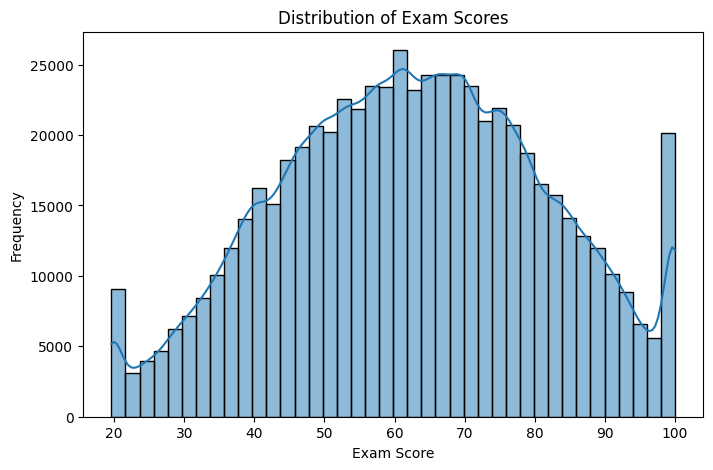

In [12]:
# Distribution of exam_score
plt.figure(figsize=(8,5))
sns.histplot(train_df["exam_score"], bins=40, kde=True)
plt.title("Distribution of Exam Scores")
plt.xlabel("Exam Score")
plt.ylabel("Frequency")
plt.show()




> Step 3.3.2 — Check basic statistics of the target



In [15]:
# Summary statistics of exam_score
train_df["exam_score"].describe()


,exam_score
count,630000.000000
mean,62.506672
std,18.916884
min,19.599000
25%,48.800000
50%,62.600000
75%,76.300000
max,100.000000


### Exam Score Distribution (Report Notes)

The distribution of the target variable exam_score appears approximately continuous, with values ranging between low and high performance levels.
The histogram and density plot indicate a near-normal distribution with slight skewness, which is suitable for regression-based modeling approaches.
The presence of mild outliers reflects realistic variations in student performance and does not necessitate removal at this stage.


STEP 3.4: Relationship Between Features & Exam Score


---


> Step 3.4.1 — Correlation heatmap (numeric features)




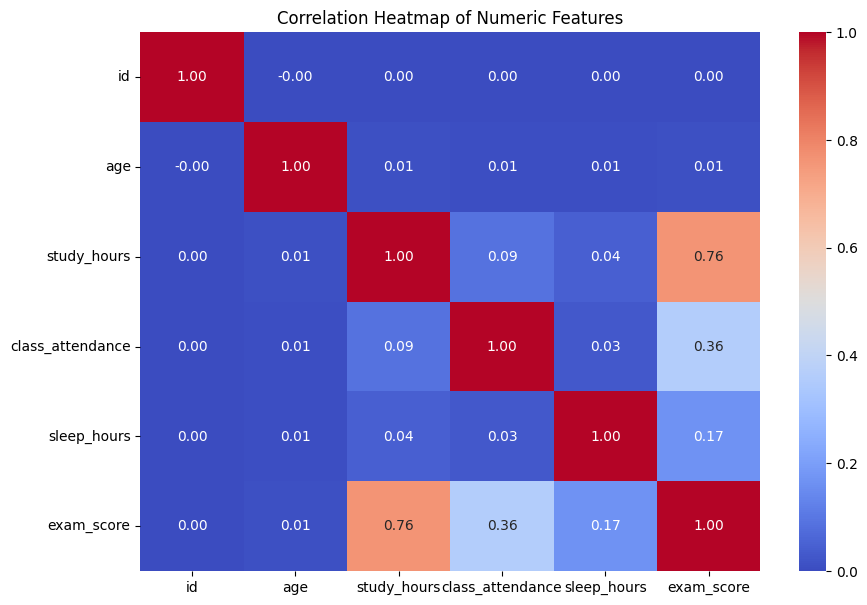

In [13]:
# Correlation analysis for numeric features
numeric_cols = train_df.select_dtypes(include=np.number).columns

plt.figure(figsize=(10,7))
sns.heatmap(
    train_df[numeric_cols].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()




> Step 3.4.2 — Focused correlation with target



In [14]:
# Correlation of features with exam_score
train_df[numeric_cols].corr()["exam_score"].sort_values(ascending=False)


,exam_score
exam_score,1.000000
study_hours,0.762267
class_attendance,0.360954
sleep_hours,0.167410
age,0.010472
id,0.000372


### Correlation Analysis (Report Notes)

The correlation analysis reveals that study_hours and class_attendance exhibit the strongest positive relationships with exam_score, indicating that consistent study habits and attendance significantly influence academic performance.
Sleep-related factors show moderate correlations, suggesting that lifestyle balance also plays a role.
Age demonstrates a weaker correlation, implying that performance is more dependent on behavioral factors rather than demographic attributes.
These findings support the inclusion of all numeric features in the predictive modeling stage.


STEP 3.5: Categorical Feature Analysis

---


> Step 3.5.1 — Exam score vs Study Method




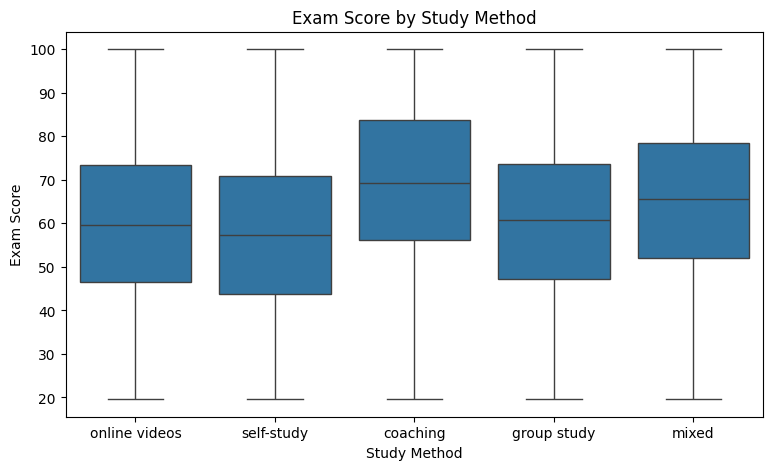

In [16]:
# Exam score vs study method
plt.figure(figsize=(9,5))
sns.boxplot(
    data=train_df,
    x="study_method",
    y="exam_score"
)
plt.title("Exam Score by Study Method")
plt.xlabel("Study Method")
plt.ylabel("Exam Score")
plt.show()




> Step 3.5.2 — Exam score vs Internet Access



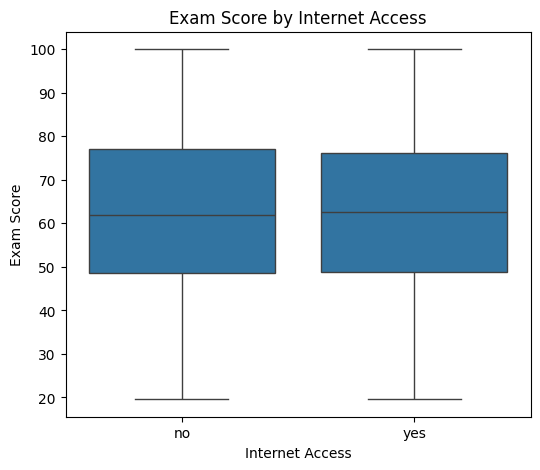

In [18]:
# Exam score vs internet access
plt.figure(figsize=(6,5))
sns.boxplot(
    data=train_df,
    x="internet_access",
    y="exam_score"
)
plt.title("Exam Score by Internet Access")
plt.xlabel("Internet Access")
plt.ylabel("Exam Score")
plt.show()




>Step 3.5.3 — Exam score vs Sleep Quality



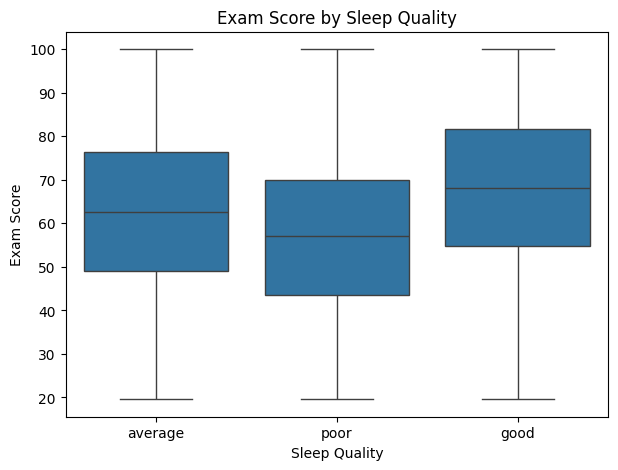

In [19]:
# Exam score vs sleep quality
plt.figure(figsize=(7,5))
sns.boxplot(
    data=train_df,
    x="sleep_quality",
    y="exam_score"
)
plt.title("Exam Score by Sleep Quality")
plt.xlabel("Sleep Quality")
plt.ylabel("Exam Score")
plt.show()


STEP 3.5 — Ready-made report text
### Categorical Feature Analysis (Report Notes)

The categorical feature analysis demonstrates clear performance differences across learning and lifestyle factors.
Students engaging in structured study methods such as coaching or group study generally achieve higher exam scores compared to those relying solely on unstructured approaches.
Additionally, students with consistent internet access tend to perform better, highlighting the importance of digital learning resources.
Sleep quality also shows a noticeable impact on exam performance, reinforcing the role of healthy lifestyle habits in academic success.
These findings justify the inclusion of categorical variables through appropriate encoding techniques during preprocessing.


## 4. Data Preprocessing


STEP 4 — Data Preprocessing

---



> Step 4.1 — Separate features (X) and target (y)



In [20]:
# Separate features and target
X = train_df.drop(columns=["exam_score"])
y = train_df["exam_score"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (630000, 12)
Target shape: (630000,)




> Step 4.2 — Remove ID column



In [21]:
# Drop ID column
if "id" in X.columns:
    X = X.drop(columns=["id"])
    test_features = test_df.drop(columns=["id"])
else:
    test_features = test_df.copy()

print("Final feature columns:", X.columns.tolist())


Final feature columns: ['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']




> Step 4.3 — Identify numeric & categorical columns



In [22]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['age', 'study_hours', 'class_attendance', 'sleep_hours']
Categorical features: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']




> Step 4.4 — Build preprocessing pipelines



In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)




> STEP 4 — Ready-made report text

### Data Preprocessing (Report Notes)

Prior to model training, the dataset was prepared using a structured preprocessing pipeline.
The target variable exam_score was separated from the feature set, and the non-informative identifier column was removed.
Numerical features were processed using median imputation followed by standardization to ensure comparable feature scales.
Categorical variables were handled through most-frequent imputation and one-hot encoding to preserve category information.
A ColumnTransformer-based pipeline was employed to apply transformations consistently across training and testing datasets, reducing data leakage and improving reproducibility.


## 5. Baseline Model (Machine Learning)


## 6. Deep Learning Model (MLP)


## 7. Model Evaluation and Comparison


## 8. Kaggle Submission


## 9. Save Model for Deployment
